# Introduction

## Open-source software to process PAM data stored in the cloud

As oceanic passive acoustic monitoring (PAM) datasets grow in volume and global coverage, the challenges of data storage and processing also grow.  This Python notebook illustrates recent developments in open-source software that help to address these challenges by:
1. pulling PAM metadata and data directly from a cloud storage platform into a data processing environment, and
2. producing standard data products that succinctly describe the ocean soundscape and its variations using hybrid millidecade band (HMB) spectra (Martin et al., 2021).

For illustration purposes here, we will process a single day of audio data using [PyPAM Based Processing (PBP)](https://github.com/mbari-org/pbp) to produce:
* an essential quality-control plot
* a daily netCDF file containing HMB spectra at 1 minute resolution
* a summary plot of the HMB spectra.

Batch processing of longer time-series can also be accomplished in a Python notebook using PBP, however more powerful deployment strategies are preferred for batch processing with PBP at scale.

The monitoring location for this example is the [Monterey Accelerated Research System (MARS) cabled observatory](https://www.mbari.org/technology/monterey-accelerated-research-system-mars/), in central Monterey Bay National Marine Sanctuary.  Data from this site are stored in AWS S3 cloud storage.

# Install PBP and fetch calibration and metadata files

This step is only required when running in Colab.  You can skip this cell if you are running this notebook in your local environment or in Binder.

In [1]:
!git clone --depth 1 --branch v1.5.0 https://github.com/mbari-org/pbp.git
!mkdir -p metadata/calibration
!mkdir -p metadata/attribute
!cp pbp/metadata/mars/*  metadata/attribute/
!cp pbp/misc/icListen1689_sensitivity_hms256kHz.nc  metadata/calibration/
!pip install -e pbp

Cloning into 'pbp'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 183 (delta 89), reused 119 (delta 74), pack-reused 0 (from 0)
Receiving objects: 100% (183/183), 2.25 MiB | 12.99 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Note: switching to '5c01a91139bfbd84143222c08d8e91e83643844c'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

Obtaining file:///content/pbp
  Installing build dependencies ... done
  Checkin

# Generate and review temporal metadata

Essential to reliable processing of any PAM data time-series, regardless of duration, is reliable temporal metadata.  To help ensure reliable processing, PBP interactively generates temporal metadata and allows the user to review it before proceeding with processing.  If the start times and durations of all relevant audio files are accurately specified, mapping of input audio data to output analysis products will be accurate.  If it is requrired to first correct known inaccuracies in available temporal metadata, PBP includes methods to apply such corrections.

Let's extract temporal metadata from input audio files stored in the cloud, for a specified time period.  The recorder for this location stores temporal metadata for each audio file in a separate xml file, and we use these xml files here.  The code below will generate essential temporal metadata for a brief period and store it in daily files in [json format](https://www.json.org/json-en.html).

In [1]:
# Audio data input specifications
wav_uri              = 's3://pacific-sound-256khz'   # cloud storage location for the input audio data
wav_prefix           = 'MARS_'       # prefix for the audio files
start_date           = '20201017'   # start date for temporal metadata extraction (YYYYMMDD)
end_date             = '20201019'   # end date for temporal metadata extraction (YYYYMMDD)
json_base_dir        = 'metadata/json' # location to store generated metadata in JSON format

# Import package modules
from pbp.meta_gen.gen_iclisten import IcListenMetadataGenerator
from pbp.logging_helper import create_logger_info
from datetime import datetime

 # a logger that only logs messages tagged as info to the console, for more verbose logging
log = create_logger_info(f'iclisten_{start_date}_{end_date}')

# Convert the start and end dates to datetime objects
start = datetime.strptime(start_date, "%Y%m%d")
end = datetime.strptime(end_date, "%Y%m%d")

# Create the metadata generator
meta_gen = IcListenMetadataGenerator(
        log=log,
        uri=wav_uri,
        json_base_dir=json_base_dir,
        start=start,
        end=end,
        prefixes=[wav_prefix],
        seconds_per_file=600)

# Generate the metadata - this will generate JSON files in the json_base_dir
meta_gen.run()

IcListenMetadataGenerator 20201017 Generating metadata for 2020-10-17 00:00:00 to 2020-10-19 00:00:00...
IcListenMetadataGenerator 20201017 Searching in s3://pacific-sound-256khz/*.wav for wav files that match the search patterns MARS_* ...
IcListenMetadataGenerator 20201017 Searching in bucket: pacific-sound-256khz-2020 prefixes: ['MARS_']
Found s3://pacific-sound-256khz-2020/10/MARS_20201016_230919.wav with timestamp 2020-10-16 23:09:19
Found s3://pacific-sound-256khz-2020/10/MARS_20201016_231919.wav with timestamp 2020-10-16 23:19:19
Found s3://pacific-sound-256khz-2020/10/MARS_20201016_232919.wav with timestamp 2020-10-16 23:29:19
Found s3://pacific-sound-256khz-2020/10/MARS_20201016_233919.wav with timestamp 2020-10-16 23:39:19
Found s3://pacific-sound-256khz-2020/10/MARS_20201016_234919.wav with timestamp 2020-10-16 23:49:19
Found s3://pacific-sound-256khz-2020/10/MARS_20201016_235919.wav with timestamp 2020-10-16 23:59:19
IcListenMetadataGenerator 20201017 Searching in bucket: p

## View daily json files
When this processing completes (in about 5 seconds), you can find and view the temporal metadata files that were just created within the directory structure of the notebook.  You will see a directory structure similar to this:

```
metadata/json/
└── 2020
    ├── 20201017.json
    ├── 20201018.json
    ├── ...
└── iclisten_coverage_20201017_20201019.jpg
```

The command below will list all of the daily files.

In [2]:
!ls -l {json_base_dir}/2020

total 96
-rw-r--r-- 1 root root 32482 Sep 23 10:39 20201017.json
-rw-r--r-- 1 root root 32482 Sep 23 10:40 20201018.json
-rw-r--r-- 1 root root 32482 Sep 23 10:41 20201019.json


Each daily json file provides the essential temporal metadata for each file that contains data for the day being processed.  

We can view the contents of a daily json file below.

In [3]:
import json

# Load JSON data from a file and print it
with open(f'{json_base_dir}/2020/20201017.json', 'r') as file:
    data = json.load(file)

print(json.dumps(data, indent=4))

[
    {
        "uri": "s3://pacific-sound-256khz-2020/10/MARS_20201016_235919.wav",
        "start": "2020-10-16T23:59:19Z",
        "end": "2020-10-17T00:09:19Z",
        "duration_secs": 600.0,
        "channels": 1
    },
    {
        "uri": "s3://pacific-sound-256khz-2020/10/MARS_20201017_000919.wav",
        "start": "2020-10-17T00:09:19Z",
        "end": "2020-10-17T00:19:19Z",
        "duration_secs": 600.0,
        "channels": 1
    },
    {
        "uri": "s3://pacific-sound-256khz-2020/10/MARS_20201017_001919.wav",
        "start": "2020-10-17T00:19:19Z",
        "end": "2020-10-17T00:29:19Z",
        "duration_secs": 600.0,
        "channels": 1
    },
    {
        "uri": "s3://pacific-sound-256khz-2020/10/MARS_20201017_002919.wav",
        "start": "2020-10-17T00:29:19Z",
        "end": "2020-10-17T00:39:19Z",
        "duration_secs": 600.0,
        "channels": 1
    },
    {
        "uri": "s3://pacific-sound-256khz-2020/10/MARS_20201017_003919.wav",
        "start": "2

## View daily temporal coverage plot
The temporal metadata generation also creates a summary plot that shows the percentage of each day that has audio data coverage.
In this example, the temporal metadata indicates that each day within this brief period was fully sampled.

It is important that the person responsible for processing a time-series first ensure that temporal coverage of input audio data is as-expected for the period to be processed.  This essential screening can identify issues such as previously unknown data gaps resulting from incomplete copying of part of the recording time-series to the storage archive.  If this plot shows the expected coverage, processing can proceed.

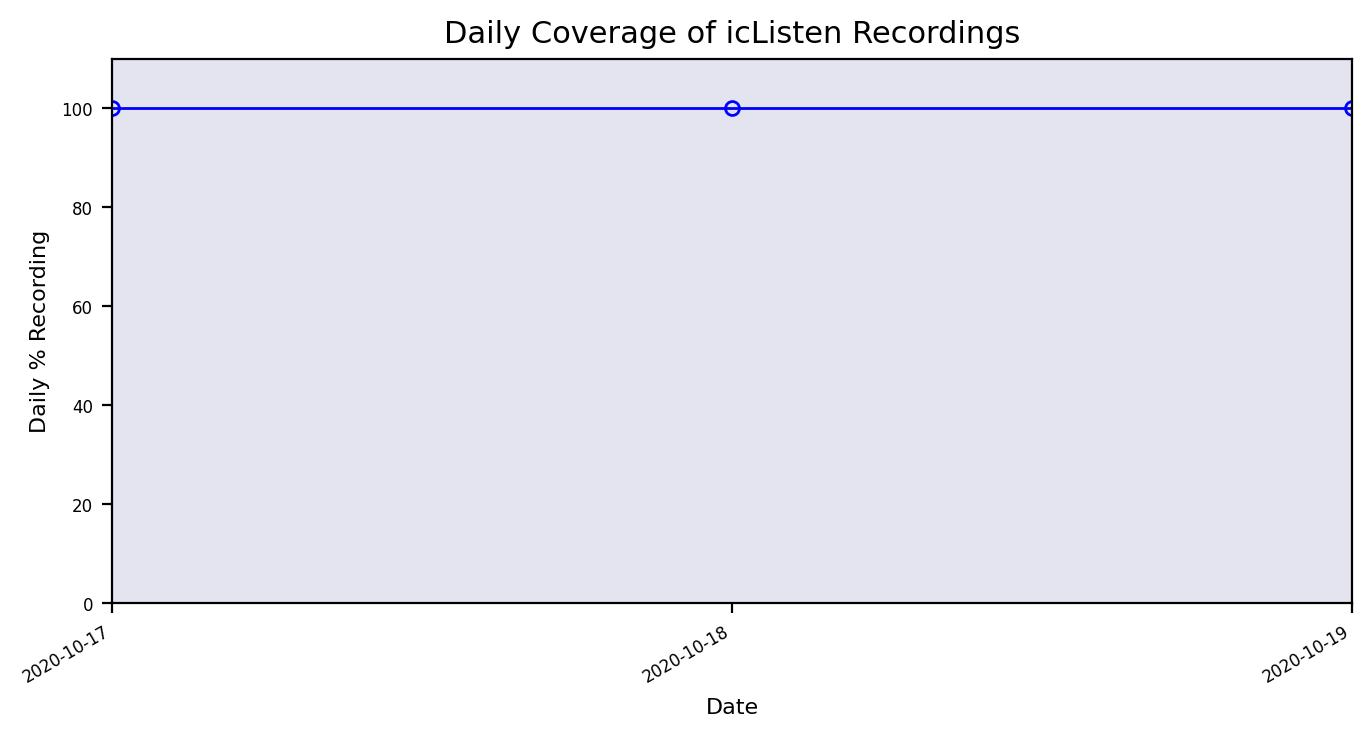

In [4]:
from IPython.display import Image, display

display(Image(filename='metadata/json/iclisten_coverage_20201017_20201019.jpg'))

# Specify other processing metadata

We next specify other metadata related to the audio recorder and the processing job.

In [5]:
# hydrophone specifications
voltage_multiplier   = 3       # required to account for actual PkPk voltage
sensitivity_uri      = 'metadata/calibration/icListen1689_sensitivity_hms256kHz.nc'  # frequency dependent hydrophone sensitivity
subset_to            = (10, 100000)   # subset frequency band for output HMB spectra, recording @ 48 kHz

# metadata files for output netCDF data products
global_attrs_uri     = 'metadata/attribute/globalAttributes.yaml'
variable_attrs_uri   = 'metadata/attribute/variableAttributes.yaml'

# output file locations
download_dir         = 'downloads'   # audio files are stored here while being processed
output_dir           = 'output'      # directory to store daily netCDF results and plots
output_prefix        = 'MARS_'       # a prefix for the name of generate files

# select a day to process (YYYYMMDD format)
date = '20201018'

# Process a day of audio data

With complete metadata specification, we can proceed to producing a daily netCDF file of HMB spectra.  

When processing large data audio archives at scale, processing steps simply occur in sequence.  For the purposes of illustration in this notebook, the main steps are detailed sequentially:
- Import package modules
- Create `HmbGen` object with the parameters
- Generate the core data product: a netCDF file of 1-minute HMB spectra
- Generate a summary plot from the netCDF file

## Import package modules

In [6]:
from pbp.simpleapi import HmbGen

from pbp import get_pbp_version
get_pbp_version()

'1.5.0'

In [7]:
# In this notebook we fetch audio files from public S3 buckets:
import boto3
import botocore
from botocore.config import Config

## Create an `HmbGen` object with the parameters

In [9]:
hmb_gen = HmbGen()

hmb_gen.set_json_base_dir(json_base_dir)
hmb_gen.set_global_attrs_uri(global_attrs_uri)
hmb_gen.set_variable_attrs_uri(variable_attrs_uri)
hmb_gen.set_sensitivity(sensitivity_uri)
hmb_gen.set_voltage_multiplier(voltage_multiplier)
hmb_gen.set_subset_to(subset_to)

config = Config(signature_version=botocore.UNSIGNED)
s3_client = boto3.client('s3', config=config)
hmb_gen.set_s3_client(s3_client)

hmb_gen.set_download_dir(download_dir)
hmb_gen.set_output_dir(output_dir)
hmb_gen.set_output_prefix(output_prefix)

hmb_gen.set_print_downloading_lines(True)

# ----- JUST FOR INITIAL CONVENIENCE: ------
hmb_gen.set_retain_downloaded_files(True)
hmb_gen.set_assume_downloaded_files(True)

## Check parameters

In [10]:
error = hmb_gen.check_parameters()
# A message is returned in case of any errors
if error:
    raise RuntimeError(f"check_parameters returned:\n{error}")

## Generate HMB product


In [11]:
result = hmb_gen.process_date(date)

# The resulting NetCDF file should have been saved under the output directory.

# Here we expose the generated dataset itself to see it displayed in the notebook:
result.dataset

pbp v1.5.0: : Processing 20201018 to generate output/MARS_20201018.nc...
::: Started processing date='20201018'
downloading s3://pacific-sound-256khz-2020/10/MARS_20201017_235919.wav
downloading s3://pacific-sound-256khz-2020/10/MARS_20201018_000919.wav
downloading s3://pacific-sound-256khz-2020/10/MARS_20201018_001919.wav
downloading s3://pacific-sound-256khz-2020/10/MARS_20201018_002919.wav
downloading s3://pacific-sound-256khz-2020/10/MARS_20201018_003919.wav
downloading s3://pacific-sound-256khz-2020/10/MARS_20201018_004919.wav
downloading s3://pacific-sound-256khz-2020/10/MARS_20201018_005919.wav
downloading s3://pacific-sound-256khz-2020/10/MARS_20201018_010919.wav
downloading s3://pacific-sound-256khz-2020/10/MARS_20201018_011919.wav
downloading s3://pacific-sound-256khz-2020/10/MARS_20201018_012919.wav
downloading s3://pacific-sound-256khz-2020/10/MARS_20201018_013919.wav
downloading s3://pacific-sound-256khz-2020/10/MARS_20201018_014919.wav
downloading s3://pacific-sound-256kh

<xarray.Dataset>
Dimensions:      (time: 1440, frequency: 2787)
Coordinates:
  * time         (time) int64 1602979200 1602979260 ... 1603065480 1603065540
  * frequency    (frequency) float32 10.0 11.0 12.0 ... 9.966e+04 9.988e+04
Data variables:
    psd          (time, frequency) float32 80.98 79.22 77.83 ... 38.23 38.2
    effort       (time) float32 60.0 60.0 60.0 60.0 60.0 ... 60.0 60.0 60.0 60.0
    sensitivity  (frequency) float64 -177.9 -177.9 -177.9 ... -180.1 -180.2
Attributes: (12/29)
    title:                     Hybrid Millidecade Band Sound Pressure Levels ...
    summary:                   To understand natural and anthropogenic sound ...
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    keywords:                  oceans, ocean acoustics, ambient noise, intens...
    keywords_vocabulary:       GCMD Science Keywords
    history:                   Original hybrid millidecade spectra were produ...
    ...                        ...
    time_coverage_duration:    P1D
    time_coverage_resolution:  P60S
    platform:                  Monterey Accelerated Research System (MARS) ca...
    instrument:                Ocean Sonics icListen HF broadband digital hyd...
    cdm_data_type:             TimeSeries
    references:                Original audio recordings are available open-a...

## Generate summary plot

We can use the `plot_dataset_summary` function in mbari-pbp:

In [12]:
from pbp.plotting import plot_dataset_summary
import xarray as xr

In [14]:
nc_filename = 'output/MARS_20201018.nc'
ds = xr.open_dataset(nc_filename, engine="h5netcdf")

In [16]:
ds

<xarray.Dataset>
Dimensions:      (time: 1440, frequency: 2787)
Coordinates:
  * time         (time) datetime64[ns] 2020-10-18 ... 2020-10-18T23:59:00
  * frequency    (frequency) float32 10.0 11.0 12.0 ... 9.966e+04 9.988e+04
Data variables:
    psd          (time, frequency) float32 ...
    effort       (time) timedelta64[ns] ...
    sensitivity  (frequency) float64 ...
Attributes: (12/29)
    title:                     Hybrid Millidecade Band Sound Pressure Levels ...
    summary:                   To understand natural and anthropogenic sound ...
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    keywords:                  oceans, ocean acoustics, ambient noise, intens...
    keywords_vocabulary:       GCMD Science Keywords
    history:                   Original hybrid millidecade spectra were produ...
    ...                        ...
    time_coverage_duration:    P1D
    time_coverage_resolution:  P60S
    platform:                  Monterey Accelerated Research System (MARS) ca...
    instrument:                Ocean Sonics icListen HF broadband digital hyd...
    cdm_data_type:             TimeSeries
    references:                Original audio recordings are available open-a...

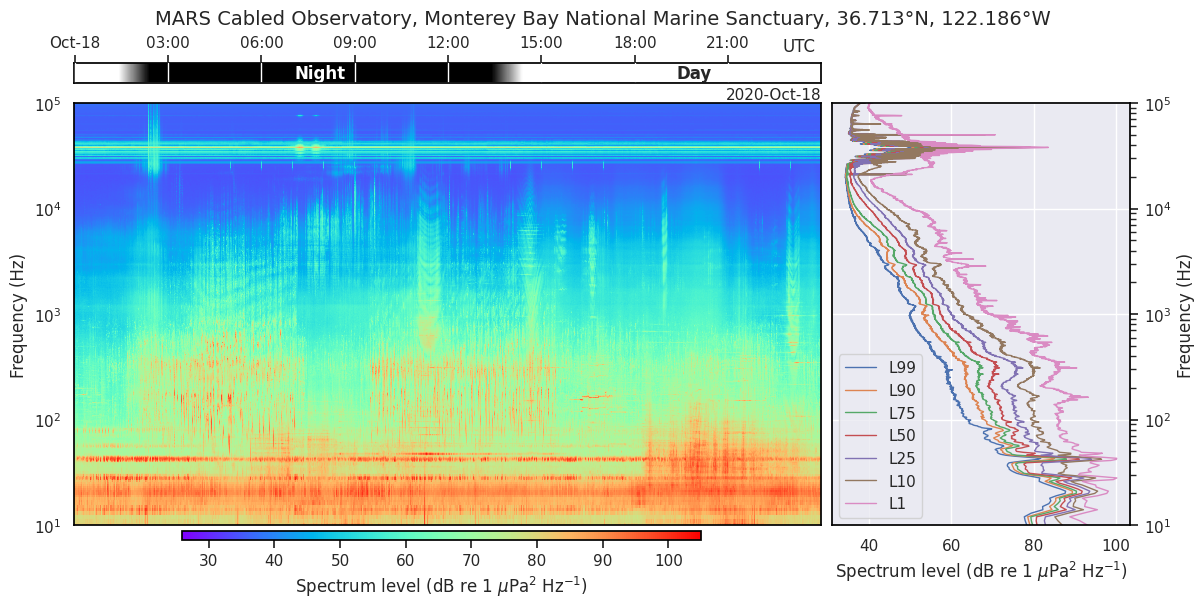

In [17]:
plot_dataset_summary(
    ds,
    lat_lon_for_solpos=(36.7128, -122.186),
    title='MARS Cabled Observatory, Monterey Bay National Marine Sanctuary, 36.713°N, 122.186°W',
    ylim=(10, 100000),
    cmlim=(26, 105),
    show=True,
)